# Objective

- Propose a tutorial on how to use our library to mine differential causal rules on Knowledge Graphs

- In this notebook, we show how :
    - to train an embedding model on our vitamin dataset
    - determine a similarity threshold
    - mine similar pairs
    - get a treatment effect for the "sex" property on the outcome "willingness to change one's diet to reduce meat consumption"

<div class="alert alert-success">
    <b>NOTE :</b>
    We strongly advice the reader to use a <b>GPU</b> as computing the similarity between instances is computationally high.
    <b>CPU</b>'s are not adapted for these operations, and using them would result in a long running time. Moreover, running the code in a python script is faster than in a notebook. This notebook was run locally on a CPU for explainability purposes.
</div>

# 1 : Imports and Parameters Definition

## Libraries Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import math
import random
import copy
import sys
import itertools
import time

In [2]:
import ampligraph
import tensorflow as tf

if ampligraph.__version__ == '1.4.0':
    print("AmpliGraph version OK")
if tf.__version__ == '1.15.2':
    print("TensorFlow version OK")

AmpliGraph version OK
TensorFlow version OK


In [3]:
from ampligraph.datasets import load_from_csv
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from ampligraph.evaluation import evaluate_performance
from ampligraph.latent_features.models import ConvE

In [4]:
sys.path.append('../similarity_search')
from pairs_mining import *
from threshold_estimation import *
from distance_threshold_estimation import *
sys.path.append('../dcr_discovery')
from metrics import *

## Data Import

In [5]:
directory_path = '../datasets'
file_name = 'vitamin_with_type.csv'
X = load_from_csv(directory_path,file_name, sep=',')

In [6]:
# checking the import
print(f"The knowledge graph is composed of {len(X)} triples")

The knowledge graph is composed of 85589 triples


In [7]:
relations_ = list(np.unique([x[1] for x in X]))

## Constant Values

In [8]:
PATH_TYPE = '22-rdf-syntax-ns#type'
TYPE_TARGET_CLASS = 'Person'

PATH_TREATMENT = ['sex']
PATH_OUTCOME = ['hasIdealDiet']

PATHS_TO_REMOVE_IN_TRAINING = [PATH_TYPE,PATH_TREATMENT[-1],PATH_OUTCOME[-1]]
TEST_SET_PROPORTION = 0.1

SAMPLING_PARAMETER = 250
STAT_PARAM = 1.96
SUPPORT_THRESHOLD = 10
SIMILARITY_THRESHOLD = 0.75
EPOCHS = 150

# 2 : Embedding Model - Training sets Definition, Training and Metrics

- For this example, we decide to train the ConvE model
- However, we recommand the reader to visit the ampligraph library to test other models

In [9]:
# defining the training sets
X_training = np.array([x for x in X if x[1] not in PATHS_TO_REMOVE_IN_TRAINING])
test_size = round(TEST_SET_PROPORTION*len(X_training))
X_train, X_test = train_test_split_no_unseen(X_training, test_size=test_size)

In [10]:
# defining the model
model = ConvE(batches_count=100, 
              seed=0, 
              epochs=EPOCHS, 
              k=150,
              eta=5,
              optimizer='adam',
              optimizer_params={'lr':1e-3},
              loss='bce',
              regularizer='LP', 
              regularizer_params={'p':3, 'lambda':1e-5},
              verbose=True)
positives_filter = X_training

In [11]:
# training the model
tf.logging.set_verbosity(tf.logging.ERROR)
model.fit(X_train, early_stopping = False)

Average Loss:   1.005610: 100%|██████████| 150/150 [21:48<00:00,  8.72s/epoch]


In [12]:
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,
                             filter_unseen=True,
                             use_default_protocol=True,
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.
Mapping set data: test
Mapping set data: filter


100%|██████████| 23/23 [00:05<00:00,  4.41batch/s]


In [13]:
model_performances = {}

mrr = mrr_score(ranks)
model_performances['mrr'] = mrr

hits_1 = hits_at_n_score(ranks, n=1)
model_performances['hits_1'] = hits_1
hits_3 = hits_at_n_score(ranks, n=3)
model_performances['hits_3'] = hits_3
hits_10 = hits_at_n_score(ranks, n=10)
model_performances['hits_10'] = hits_10

In [14]:
model_performances = {key:[value] for key,value in model_performances.items()}
df_model_performances = pd.DataFrame.from_dict(model_performances)

In [15]:
df_model_performances

,mrr,hits_1,hits_3,hits_10
0,0.325938,0.233715,0.392452,0.484245


In [16]:
if not os.path.exists('results'):
    os.mkdir('results')
df_model_performances.to_csv('results/model_performances.csv',header=True,index=False)

# 3 : Determining the distance threshold for matching 

- In this part, we sample a set of pairs and for each of them compute its (i) distance and (ii) similarity measure
- Then, we model the relation between the 2 measures and obtain a distance threshold based on the given parameter on the similarity

In [17]:
list_target_class_instances = [x[0] for x in X if x[1]==PATH_TYPE and x[2]==TYPE_TARGET_CLASS]

In [18]:
# defining the end nodes for the similarity search
all_types = list(np.unique([x[2] for x in X if x[1] == '22-rdf-syntax-ns#type']))
type_end = all_types

In [19]:
from parameters import dic_functionality
dic_functionality = {key:value for key,value in dic_functionality.items() if key not in [PATH_OUTCOME[0],PATH_TREATMENT[0]]}

In [21]:
subset_points = get_subset_points_for_threshold(measures)

In [22]:
print(len(subset_points))

199


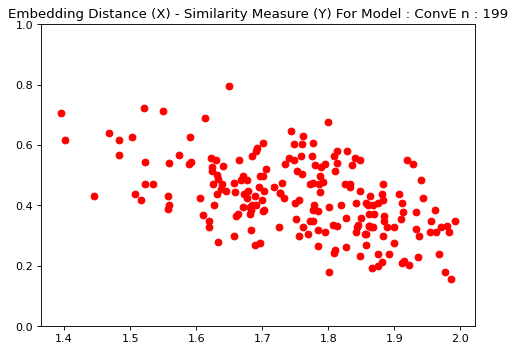

In [23]:
model_name = 'ConvE'
plot_distribution_measures(subset_points,model_name)

In [24]:
model_degree = 1
estimation_model, r_squared = fit_model_on_measures(subset_points,model_degree)

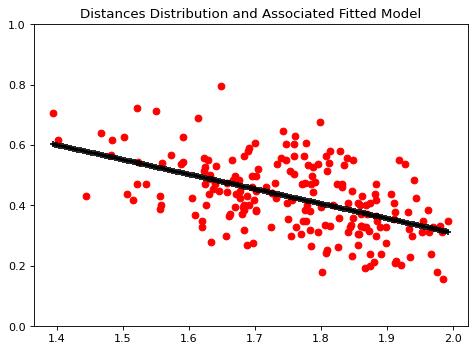

In [25]:
fitted_model = estimation_model
plot_distribution_and_model(measures,fitted_model)

In [26]:
distance_threshold = get_distance_threshold(fitted_model,SIMILARITY_THRESHOLD)

In [27]:
distance_threshold

1.0914111675101243

<div class="alert alert-success">
    <b>NOTE :</b>
    This notebook only shows how our functions work. More points should be used to estimate distance_threshold.
    As the points have a normal distribution on ths distance, the 'get_subset_points_for_threshold' function should be used to have an equivalent number of points per distance insterval.
</div>

# 4 : Building the pairs of similar instances

- We mined the distance threshold, we can now create the pairs
- Showing the different strategies to obtain the pairs

In [28]:
print(f"There are {len(list_target_class_instances)} instances of the target class.")

There are 1714 instances of the target class.


## 4.1 : Building the pairs of similar instances : No condition on the treatment

In [29]:
# building the similarity matrix
mode = 'mixed'
df_similarity,df_to_numpy = get_matrix_similarity_pairs(model,list_target_class_instances,mode=mode)

### 4.1.1 : Using the distance threshold

In [30]:
strategy = 'greedy'
pairs_similar_instances = get_pairs_from_matrix_and_threshold(df_similarity,distance_threshold,strategy=strategy)

In [31]:
print(f"{len(pairs_similar_instances)} pairs have been created with the greedy strategy.")

282 pairs have been created with the greedy strategy.


### 4.1.2 : Using the proportion of matched instances

In [32]:
proportion = 0.0001
pairs_closer_instances = get_pairs_from_matrix_and_proportion(df_similarity,proportion=proportion)

In [33]:
print(f"{len(pairs_closer_instances)} pairs have been created.")

147 pairs have been created.


## 4.2 : Building the pairs of similar instances : Different treatment values

In [34]:
mode = 'treatment_sort'

In [35]:
treatment_values = list(np.unique([x[2] for x in X if x[1]==PATH_TREATMENT[0]]))
t0 = treatment_values[0]
t1 = treatment_values[1]

In [36]:
instances_t0 = list(np.unique([x[0] for x in X if x[2]==t0]))
instances_t1 = list(np.unique([x[0] for x in X if x[2]==t1]))

In [37]:
df_similarity,df_to_numpy = get_matrix_similarity_pairs(model,list_target_class_instances,mode=mode,instances_t0=instances_t0,instances_t1=instances_t1)

### 4.2.1 : Using the distance threshold

In [38]:
distance_thr = distance_threshold + 0.2

In [39]:
strategy = 'greedy'
pairs_similar_instances = get_pairs_from_matrix_and_threshold(df_similarity,distance_thr,strategy=strategy,mode=mode)

In [40]:
len(pairs_similar_instances)

126

### 4.2.2 : Using the proportion of matched instances

In [41]:
proportion = 0.001
mode = 'treatment_sort'
pairs_closer_instances = get_pairs_from_matrix_and_proportion(df_similarity,proportion=proportion,mode=mode)

In [42]:
print(f"{len(pairs_closer_instances)} pairs have been created.")

446 pairs have been created.


# 5 : Computing the treatment effect

- Given the set of similar pairs, we aim to compute the treatment effect

In [43]:
path_flesh = PATH_OUTCOME + ['fleshIntensity']

In [45]:
causal_metric, causal_metric_IC = compute_metric(pairs_closer_instances,X,PATH_TREATMENT,PATH_OUTCOME,t0,t1,stat_param=1.96)

In [46]:
print('Treatment Studied : ',PATH_TREATMENT)
print('Value t0 : ',t0)
print('Value t1 : ',t1)
print('On the outcome : ',PATH_OUTCOME)
print('Causal Metric : ',causal_metric)
print('Confidence Interval: ',causal_metric_IC)

Treatment Studied :  ['sex']
Value t0 :  Man
Value t1 :  Woman
On the outcome :  ['hasIdealDiet']
Causal Metric :  1.075
Confidence Interval:  [0.793, 1.458]
